# **Part II: Analysis**
team member: Shaoying Zheng, Zhongrui Ning, Xiao Pu


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from wordcloud import WordCloud
import matplotlib.ticker as mticker

In [2]:
# load data
df = pd.read_csv('Projectdata/job_company_pair.csv')
df.head()

,job_id,company_id,skill_abr,skill_name,industry_id,max_salary,med_salary,min_salary,pay_period,industry_name,name,company_size,country,employee_count,follower_count,employee_follower_ratio,annual_min_salary,annual_max_salary,annual_med_salary,skill_category
0,921716,2774458.0,MRKT,Marketing,44,20.0,NaN,17.0,HOURLY,Real Estate,Corcoran Sawyer Smith,2.0,US,402,2351,0.170991,35360.0,41600.0,36608.0,Creative
1,921716,2774458.0,SALE,Sales,44,20.0,NaN,17.0,HOURLY,Real Estate,Corcoran Sawyer Smith,2.0,US,402,2351,0.170991,35360.0,41600.0,36608.0,Business
2,10998357,64896719.0,MNFC,Manufacturing,32,65000.0,NaN,45000.0,YEARLY,Restaurants,The National Exemplar,1.0,US,15,40,0.375000,45000.0,65000.0,49000.0,Other
3,10998357,64896719.0,MGMT,Management,32,65000.0,NaN,45000.0,YEARLY,Restaurants,The National Exemplar,1.0,US,15,40,0.375000,45000.0,65000.0,49000.0,Administration
4,3899530060,64896719.0,MNFC,Manufacturing,32,85000.0,NaN,55000.0,YEARLY,Restaurants,The National Exemplar,1.0,US,15,40,0.375000,55000.0,85000.0,61000.0,Other


In [3]:
#df[df['annual_max_salary']<df['annual_med_salary']]

## Descriptive Statistics: 

Firstly, let's check the columns of our data

In [4]:
df.columns

Index(['job_id', 'company_id', 'skill_abr', 'skill_name', 'industry_id',
       'max_salary', 'med_salary', 'min_salary', 'pay_period', 'industry_name',
       'name', 'company_size', 'country', 'employee_count', 'follower_count',
       'employee_follower_ratio', 'annual_min_salary', 'annual_max_salary',
       'annual_med_salary', 'skill_category'],
      dtype='object')

In those columns, `job_id` is the unique value for each job
For the purpose of our analysis, which aiming at job hunting recommendation, we would focus on those following columns: 
- Salary of the job: described by `annual_min_salary`, `annual_med_salary` and `annual_max_salary`
- Skills the job needs: described by `skill_abr`, `skill_name` specifically and `skill_catogory` generally. 
- Size and popularity of the company：described by `employee_count`,`follower_count`, `company_size` and `employee_follower_ratio`
- Industry fields: described by `industry_name` and `industry_id`

### Salary description

`annual_min_salary`, `annual_med_salary` and `annual_max_salary` are all numerical float variables, each columns contains the salary description of the job, but not every job have those three kind of salary descriptions (minimum, median and maximum). 

In [5]:
df[['annual_min_salary', 'annual_med_salary', 'annual_max_salary']].describe().T

,count,mean,std,min,25%,50%,75%,max
annual_min_salary,307895.0,134269.147587,3.112620e+06,1.0,43680.0,70800.0,110000.0,499200000.0
annual_med_salary,307895.0,144567.984561,3.228537e+06,1.0,49088.0,77840.0,118560.0,513760000.0
annual_max_salary,307895.0,185763.332460,3.704769e+06,1.0,67392.0,103582.0,156000.0,572000000.0


- We handled the missing values in part 1, and filled all the missing values
- In Part I, we have briefly described the relationship between `annual_med_salary` and occupation type/company size. 
- We didn't use `annual_min_salary` and `annual_max_salary` before. 
- We may use `annual_med_salary` as the prediction variable. 

### Skills description

`skill_abr`, `skill_name` and `skill_category` are all text variables, contains the arbitrary of the skills, the full name of the skills and the category of the skills. 

In [6]:
df. skill_category.value_counts().describe()

count         9.000000
mean      34210.555556
std       40375.064517
min        1066.000000
25%        4552.000000
50%       28084.000000
75%       37179.000000
max      132184.000000
Name: count, dtype: float64

In [7]:
df. skill_category.value_counts().head(10)

skill_category
Other                      132184
Administration              48252
Business                    37179
Technical & Engineering     36144
Finance                     28084
Creative                    15942
Legal & Compliance           4552
Human Resources              4492
Logistics & Operations       1066
Name: count, dtype: int64

### Size and popularity of the company analysis
`employee_count`,`follower_count` and `company_size` are columns that describes the number of employees, size of the company and number of followers in Leaderboard, these attributes can help us understand the size of the company and its employees, where the size of the company is described by an integer from 1 to 7, with size increasing with the number

In [9]:
df[['employee_count', 'follower_count', 'company_size']].describe().T

,count,mean,std,min,25%,50%,75%,max
employee_count,307895.0,3.745682e+04,9.580817e+04,0.0,1196.0,8246.0,29279.0,751125.0
follower_count,307895.0,1.596424e+06,4.496000e+06,0.0,58137.0,245879.0,1350359.0,32702835.0
company_size,302363.0,5.601906e+00,1.800075e+00,1.0,5.0,7.0,7.0,7.0


As can be seen from the description, nearly half of the jobs in this dataset come from larger companies, with fewer jobs available at smaller companies, while the number of employees varies considerably among similarly sized companies, which may be related to the industrial sector to which the companies belong to. 

In [11]:
df.employee_follower_ratio.describe()

/home/codespace/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    3.078910e+05
mean              inf
std               NaN
min      0.000000e+00
25%      5.981894e-03
50%      2.937550e-02
75%      8.098834e-02
max               inf
Name: employee_follower_ratio, dtype: float64

In the analysis of  `emoloyee_follower_ratio`, we can see that the number of employees/followers ratio for each company seems to be very low, which also suggests that the job market is very competitive. 

### Industry fields analysis

In [16]:
print('The 10 industrial sectors offering the most jobs', df.industry_name.value_counts().head(10), '\n')
print('The 10 industrial sectors offering the least jobs', df.industry_name.value_counts().tail(10), '\n')

The 10 industrial sectors offering the most jobs industry_name
Hospitals and Health Care        20953
Staffing and Recruiting          18102
Financial Services               17578
IT Services and IT Consulting    17387
Retail                           17051
Software Development             12551
Banking                          10456
Manufacturing                     9404
Pharmaceutical Manufacturing      6954
Insurance                         6133
Name: count, dtype: int64 

The 10 industrial sectors offering the least jobs industry_name
Security Systems Services                 2
Household Services                        2
Packaging & Containers                    2
Conservation Programs                     2
Program Development                       2
Computer Hardware                         2
Industrial Automation                     2
Computer Networking                       2
Transportation Equipment Manufacturing    2
E-learning                                1
Name: count, dt

From the analysis we can see that industries such as healthcare and human resources are providing the most jobs, while the industrial sectors that are nearing job saturation are security systems, computer networks, etc., but we can see that these sectors overlap in some ways.

## Inferential Statistics

We've briefly seen the relationship between salary and skill categories .Let's take a deeper look into the salary by different skill categories.

In [ ]:
print(df.groupby('skill_category')['annual_med_salary'].describe())

                            count           mean           std   min      25%  \
skill_category                                                                  
Administration            48252.0   80716.002925  2.853395e+05  12.4  43555.2   
Business                  37179.0  118207.772261  2.057983e+06   1.0  42640.0   
Creative                  15942.0  101748.333261  7.301018e+05  21.0  54080.0   
Finance                   28084.0  174248.559591  4.044364e+06  18.8  61360.0   
Human Resources            4492.0   92033.632428  4.612057e+04  18.0  59468.0   
Legal & Compliance         4552.0  771595.947244  1.506925e+07  18.8  74000.0   
Logistics & Operations     1066.0   63395.541538  3.984470e+04  18.4  39442.0   
Other                    132184.0  146350.677067  2.999842e+06  12.4  48963.2   
Technical & Engineering   36144.0  176184.661872  3.133912e+06   1.0  62500.0   

                              50%       75%          max  
skill_category                                   

We first filter those extreme values before doing tests to the data.

In [ ]:
df_filtered = df[(df['annual_med_salary'] >= 7500) & (df['annual_med_salary'] <= 1000000)]

Since the distribution of salaries is skewed rather than simply normal, we chose to use the Kruskal-Wallis H Test. 

We want to check if median salaries have any statistically significant difference between different skill categories to help job seekers to enrich their skills to be more competitive in the workforce and to choose a career in the future based on their own circumstances, preferences, and salary level.

H0: The distribution of median salaries across the different job categories is the same.

H1: There is at least one job category where the distribution of median salaries is different from the others.

### [Kruskal-Wallis H Test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test)


The formula for the Kruskal-Wallis H test is as follows:

$$
H = \frac{12}{N(N+1)} \sum_{i=1}^{k} \frac{R_i^2}{n_i} - 3(N+1)
$$

where:

- \( N \) is the total sample size.
- \( k \) is the number of categories.
- \( R_i \) is the rank sum for each group.
- \( n_i \) is the number of samples in each group.



In [ ]:
from scipy.stats import kruskal

# Assuming `df` is your DataFrame and `salary` is the column with median salary
categories = df_filtered['skill_category'].unique()
salaries = [df_filtered[df_filtered['skill_category'] == cat]['annual_med_salary'] for cat in categories]

# Perform Kruskal-Wallis test
stat, p_value = kruskal(*salaries)

print("Kruskal-Wallis H-statistic:", stat)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference in median salaries between job categories.")
else:
    print("There is no statistically significant difference in median salaries between job categories.")


Kruskal-Wallis H-statistic: 12258.961010119081
p-value: 0.0
There is a statistically significant difference in median salaries between job categories.


Based on the Kruskal-Wallis H test, we reject the null hypothesis at the 0.05 significance level. This indicates that there is a statistically significant difference in the distribution of median salaries across different job categories.

Let's then add labels to categorize the salary and do some tests.

In [ ]:
def categorize_salary(group):
    low_salary_threshold = group['annual_med_salary'].quantile(0.25)
    high_salary_threshold = group['annual_med_salary'].quantile(0.75)
    if (low_salary_threshold==0):
        print('found')
    #print(f"Low Salary Threshold: {low_salary_threshold}, High Salary Threshold: {high_salary_threshold}")
    if low_salary_threshold == high_salary_threshold: 
        if group['annual_med_salary'].min() == group['annual_med_salary'].max():    
            group['salary_level'] = 'Medium Salary'
            return group
        else:     
            low_salary_threshold = group['annual_med_salary'].min()
            high_salary_threshold = group['annual_med_salary'].max()
    group['salary_level'] = pd.cut(group['annual_med_salary'], 
                                   bins=[0, low_salary_threshold, high_salary_threshold, float('inf')], 
                                   labels=['Low Salary', 'Medium Salary', 'High Salary'])
    return group
df_labeled = df.groupby('industry_name').apply(categorize_salary).reset_index(drop=True)

#print(df[['industry_name', 'annual_med_salary', 'salary_level']].head())


/tmp/ipykernel_5914/964701893.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_labeled = df.groupby('industry_name').apply(categorize_salary).reset_index(drop=True)


In [ ]:
df_labeled['industry_name'].value_counts().head(10)

industry_name
Hospitals and Health Care        20953
Staffing and Recruiting          18102
Financial Services               17578
IT Services and IT Consulting    17387
Retail                           17051
Software Development             12551
Banking                          10456
Manufacturing                     9404
Pharmaceutical Manufacturing      6954
Insurance                         6133
Name: count, dtype: int64

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency


contingency_table = pd.crosstab(df_labeled['skill_category'], df_labeled['salary_level'])
print(contingency_table)

#chi2 test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)


if p_value < 0.05:
    print("There are significant differences in salary levels across skill categories.")
else:
    print("There are no significant differences in salary levels across skill categories.")





salary_level             High Salary  Low Salary  Medium Salary
skill_category                                                 
Administration                  9597       14456          24194
Business                        7267       12740          17165
Creative                        3893        3723           8323
Finance                         7322        6067          14692
Human Resources                 1208         880           2403
Legal & Compliance              1697         730           2125
Logistics & Operations           102         466            498
Other                          32221       33448          66500
Technical & Engineering        11482        6493          18162
Chi-square statistic: 5042.390829127417
p-value: 0.0
Degrees of freedom: 16
There are significant differences in salary levels across skill categories.


Observed:
 salary_level             High Salary  Low Salary  Medium Salary
skill_category                                                 
Administration                  9597       14456          24194
Business                        7267       12740          17165
Creative                        3893        3723           8323
Finance                         7322        6067          14692
Human Resources                 1208         880           2403
Legal & Compliance              1697         730           2125
Logistics & Operations           102         466            498
Other                          32221       33448          66500
Technical & Engineering        11482        6493          18162

Expected:
 salary_level              High Salary    Low Salary  Medium Salary
skill_category                                                    
Administration           11720.961504  12381.381242   24144.657253
Business                  9030.438805   9539.260546   18602.300649
Creat

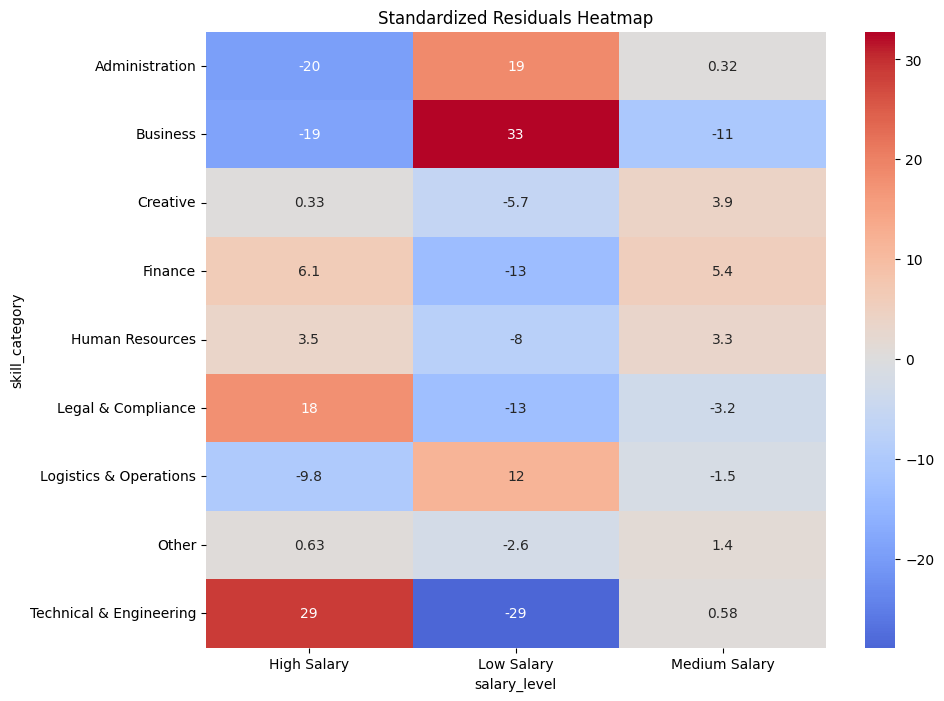

In [ ]:
observed = contingency_table.values
expected = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)

# calculate deviation
deviation = observed - expected


print("Observed:\n", contingency_table)
print("\nExpected:\n", expected)
print("\nDeviation:\n", deviation)



# calculate std_residuals
standardized_residuals = (observed - expected) / np.sqrt(expected)

print("\nStandardized Residuals:\n", standardized_residuals)


plt.figure(figsize=(10, 8))
sns.heatmap(standardized_residuals, annot=True, cmap="coolwarm", center=0)
plt.title("Standardized Residuals Heatmap")
plt.show()


We see that Technical & Engineering and Legal & Compliance skills tend to relate more with High Salary.
Business and Administration skills are predominantly in the Low Salary category.


## Graphical Analysis

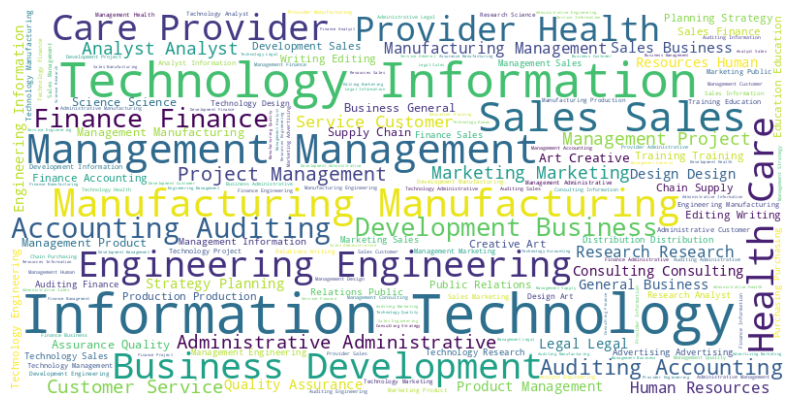

In [ ]:
text = ' '.join(df['skill_name'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We first use word cloud to have a general look at the most common skills accross all industries. It seems that Information technology and sales are the hottest. Let's check this in a more readable way.

In [ ]:
skill_counts = df['skill_name'].value_counts().reset_index()
skill_counts.columns = ['skill_name', 'count']

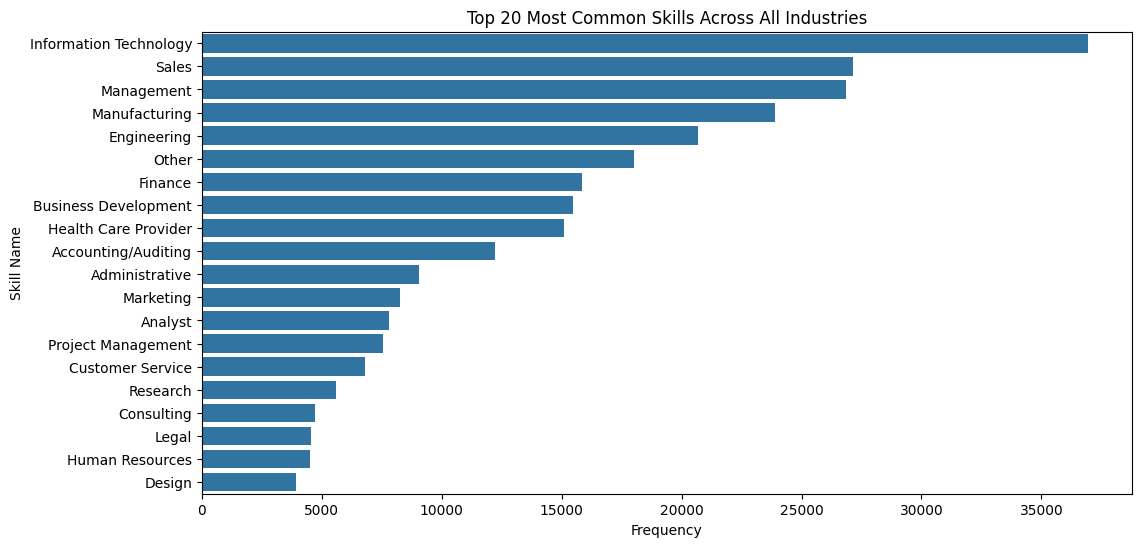

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=skill_counts.head(20), x='count', y='skill_name')
plt.title("Top 20 Most Common Skills Across All Industries")
plt.xlabel("Frequency")
plt.ylabel("Skill Name")
plt.show()

Let's then check the heatmap to see how job requirements vary across different industries.

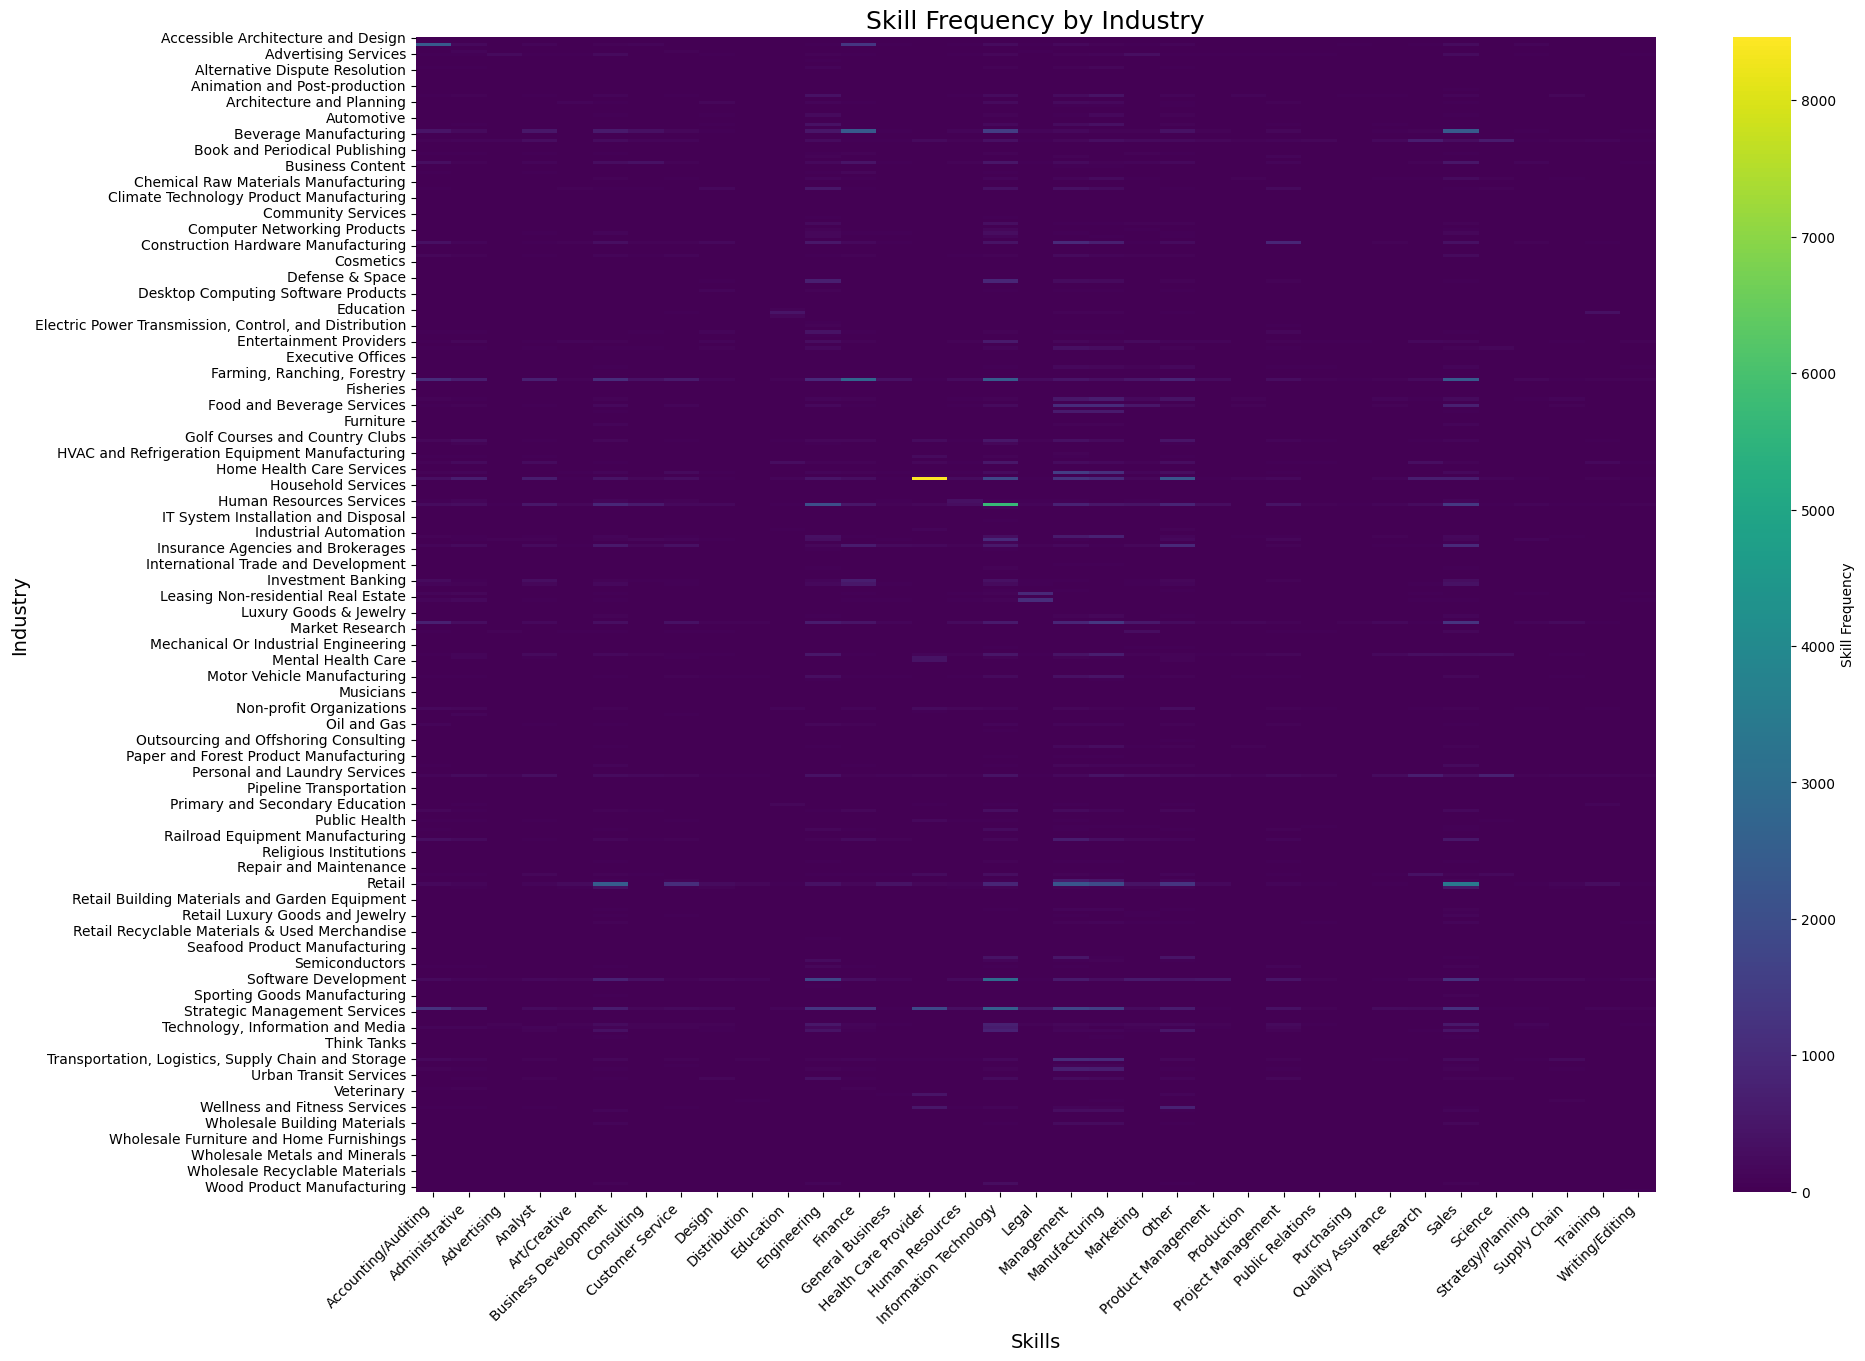

In [ ]:
industry_skill_counts = df.groupby(['industry_name', 'skill_name']).size().unstack(fill_value=0)
plt.figure(figsize=(20, 15))
sns.heatmap(
    industry_skill_counts, 
    cmap="viridis",  
    cbar_kws={'label': 'Skill Frequency'}  
)


plt.title("Skill Frequency by Industry", fontsize=18)
plt.xlabel("Skills", fontsize=14)
plt.ylabel("Industry", fontsize=14)


plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

It's unreadable. So we filter the data.

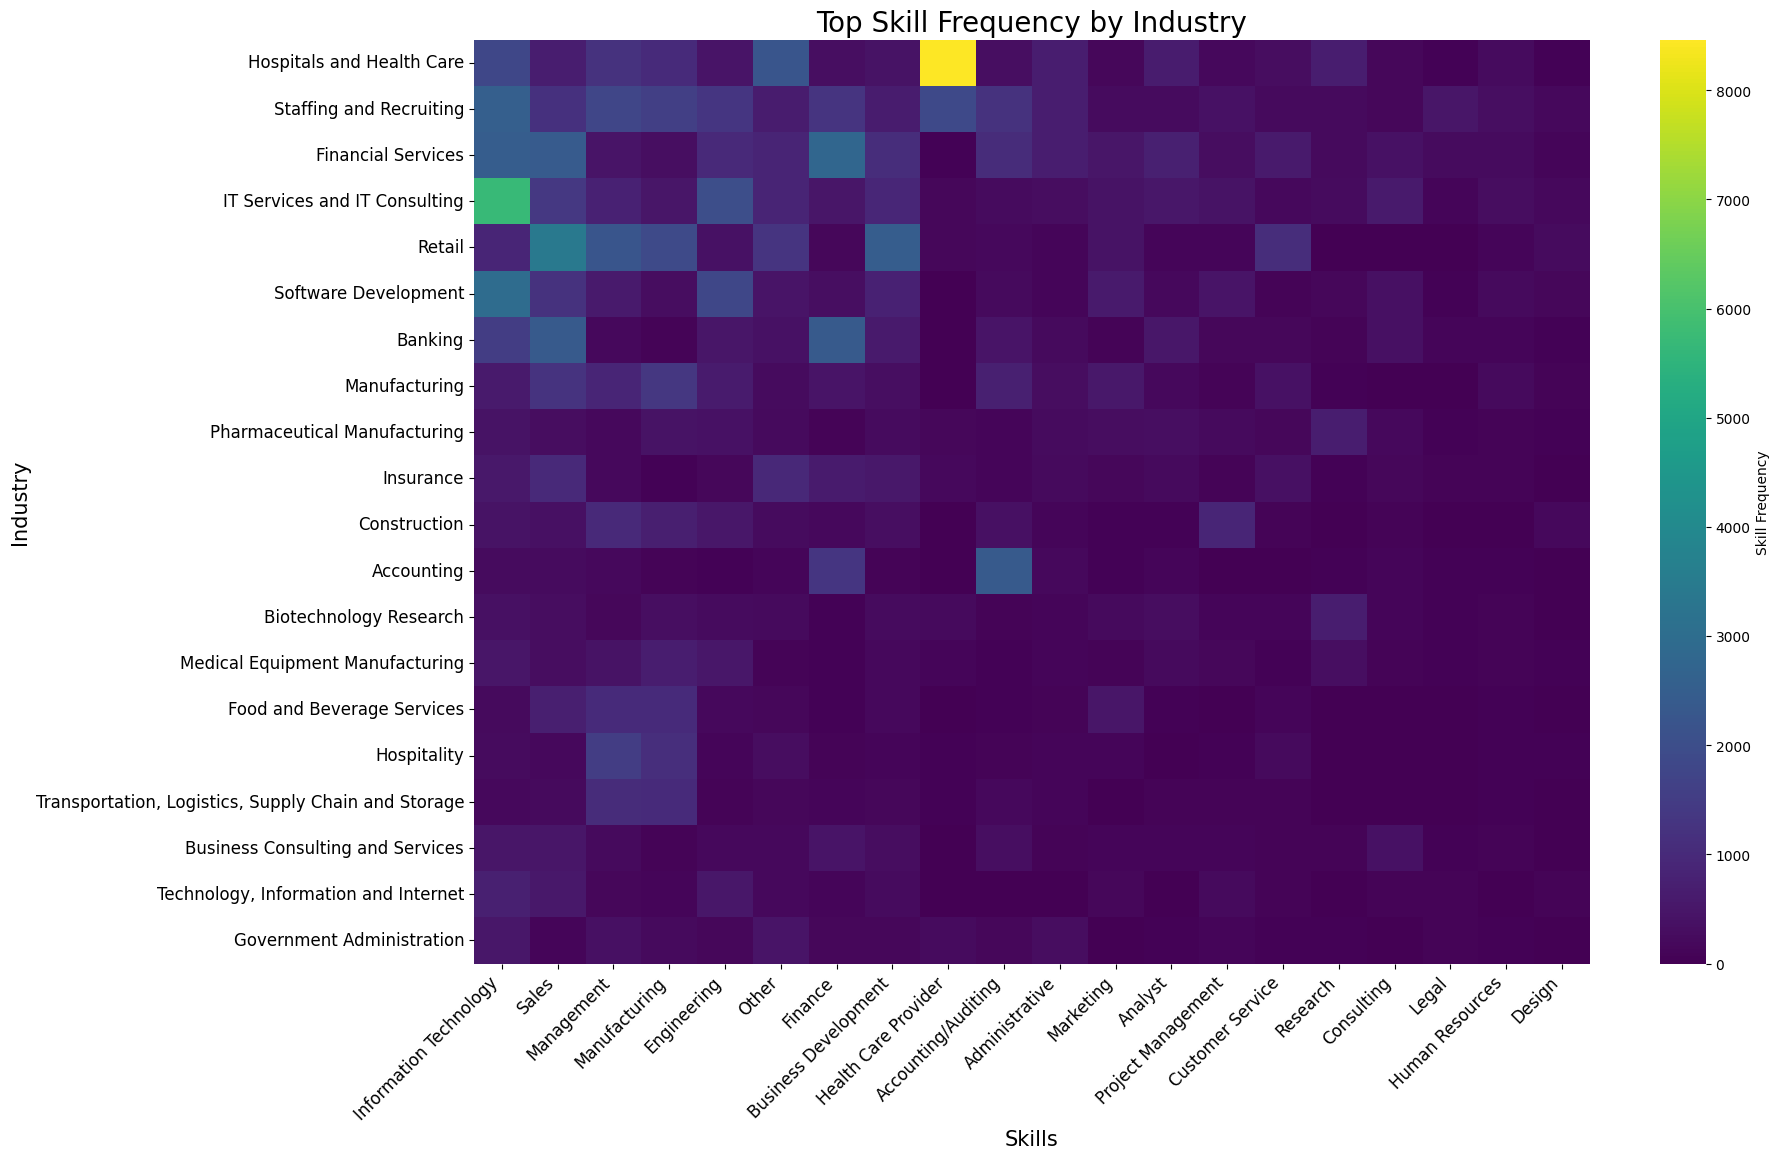

In [ ]:
top_industries = industry_skill_counts.sum(axis=1).nlargest(20).index
top_skills = industry_skill_counts.sum(axis=0).nlargest(20).index


filtered_data = industry_skill_counts.loc[top_industries, top_skills]

plt.figure(figsize=(18, 12))
sns.heatmap(
    filtered_data, 
    cmap="viridis", 
    linewidths=0,  
    cbar_kws={'label': 'Skill Frequency'}
)


plt.title("Top Skill Frequency by Industry", fontsize=20)
plt.xlabel("Skills", fontsize=15)
plt.ylabel("Industry", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We see that skills such as Information Technology, Sales, and Management have high demand across multiple industries, reflecting their importance and versatility in the modern workplace. There are also industry-Specific Skills like healthcare skills in the medical field, engineering skills in manufacturing and do not hold a dominant position in cross-industry comparisons.


Then, let's check difference of scale and influence(i.e., number of employee, number of follower and employee-follower ratio) for companies from different industries

In [ ]:
# First, let's check difference of scale and influence(i.e., number of employee, number of follower and employee-follower ratio) for companies from different industries
# Compute industries with most industries
scale= df.groupby('industry_name')[['employee_count', 'follower_count']].sum()
scale.reset_index(inplace=True)
top_10_scale = scale.sort_values('employee_count',ascending=False).head(10)
top_10_scale

,industry_name,employee_count,follower_count
295,Software Development,2735921688,123308028502
146,IT Services and IT Consulting,900214499,36040992463
29,Banking,679264275,11013292195
107,Financial Services,621679063,15159130878
265,Retail,510721231,7710433210
138,Hospitals and Health Care,447644450,14301106420
309,"Technology, Information and Internet",378823148,41199499094
183,Manufacturing,303425723,20313542172
39,Business Consulting and Services,297442302,9494488933
157,Information Services,295346178,33179466031


We can see top 10 industries with the most job postings. We can see that industries with the most job postings are IT, Finance, and Healthcare.

In [ ]:
top_10_influence = scale.sort_values('follower_count',ascending=False).head(10)
top_10_influence

,industry_name,employee_count,follower_count
295,Software Development,2735921688,123308028502
309,"Technology, Information and Internet",378823148,41199499094
146,IT Services and IT Consulting,900214499,36040992463
157,Information Services,295346178,33179466031
183,Manufacturing,303425723,20313542172
304,Staffing and Recruiting,129189311,16792946067
107,Financial Services,621679063,15159130878
138,Hospitals and Health Care,447644450,14301106420
115,Food and Beverage Services,220402771,14058936153
29,Banking,679264275,11013292195


We can see top 10 industries with the most followers. We can see that industries with the most followers are similar to industries with the most job postings, while adding food and beverage services in.

/tmp/ipykernel_5914/3319563960.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right',rotation_mode="anchor")
/tmp/ipykernel_5914/3319563960.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right',rotation_mode="anchor")
/tmp/ipykernel_5914/3319563960.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right',rotation_mode="anchor")


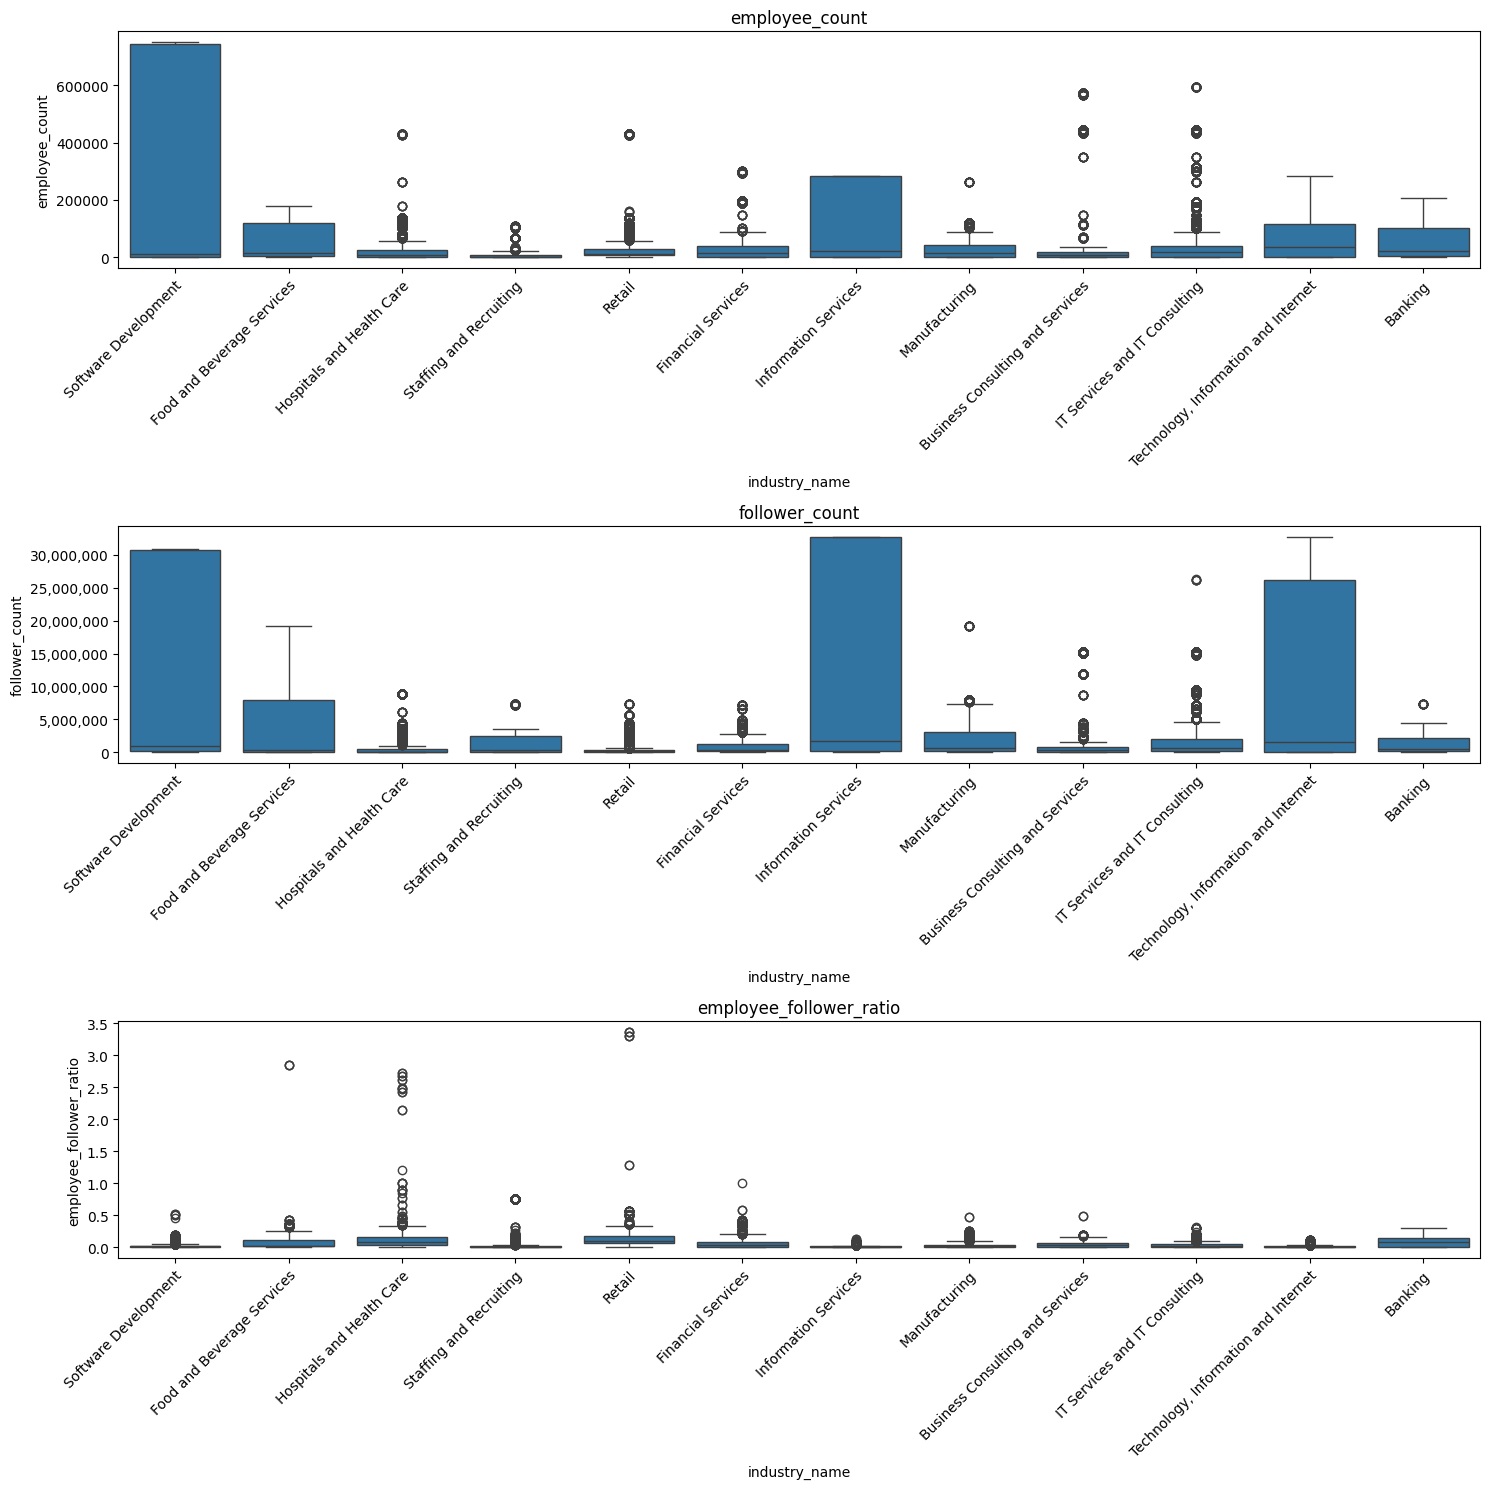

In [ ]:
# For different industries within top 10 scale and influence, check the distribution of employee_count, follower_count and employee-follower ratio
top_10_industry = list(set(top_10_scale['industry_name']).union(set(top_10_influence['industry_name'])))
top_10_industry_df = df[df['industry_name'].isin(top_10_industry)]
top_10_industry_df = top_10_industry_df[['industry_name', 'employee_count', 'follower_count', 'employee_follower_ratio']]
# create subsets for each industries and draw boxplot
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for i, col in enumerate(['employee_count', 'follower_count', 'employee_follower_ratio']):
    sns.boxplot(x='industry_name', y=col, data=top_10_industry_df, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right',rotation_mode="anchor")
ax[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

We can see that software development and Information services industries have the highest overall employee count overall. Which should be the most popular industries that college students should focus on.

## Compartive Analysis

For this part, we will focus on company size's impact on skill requirements.

In [ ]:
# Group by company size
company_size_skill = df_labeled.groupby(['company_size','skill_category']).size().unstack()
company_size_skill= company_size_skill.div(company_size_skill.sum(axis=1), axis=0) * 100
company_size_skill = company_size_skill.fillna(0)
company_size_skill.reset_index(inplace=True)
# company_size_skill = company_size_skill.melt(id_vars='company_size', var_name='skill_category', value_name='percentage')
company_size_skill

skill_category,company_size,Administration,Business,Creative,Finance,Human Resources,Legal & Compliance,Logistics & Operations,Other,Technical & Engineering
0,1.0,17.235678,13.714144,6.547078,11.407787,1.388774,2.298090,0.049599,33.322311,14.036538
1,2.0,14.201581,8.296740,6.524771,12.233301,1.420675,2.562381,0.180813,42.919874,11.659865
2,3.0,16.401460,10.828684,6.730041,12.357925,2.252532,1.880554,0.358201,37.914170,11.276435
3,4.0,14.875261,8.973514,4.170788,9.929663,1.555116,2.329926,0.236290,46.669964,11.259479
4,5.0,15.148697,10.264058,4.554786,8.260374,1.687867,1.398368,0.475480,44.716203,13.494166
5,6.0,16.415833,12.137858,4.737001,8.127022,2.110768,1.520054,0.443976,42.508842,11.998645
6,7.0,15.773473,13.581293,5.142469,8.392251,1.177270,1.018791,0.340891,43.680585,10.892978


<Figure size 2000x800 with 0 Axes>

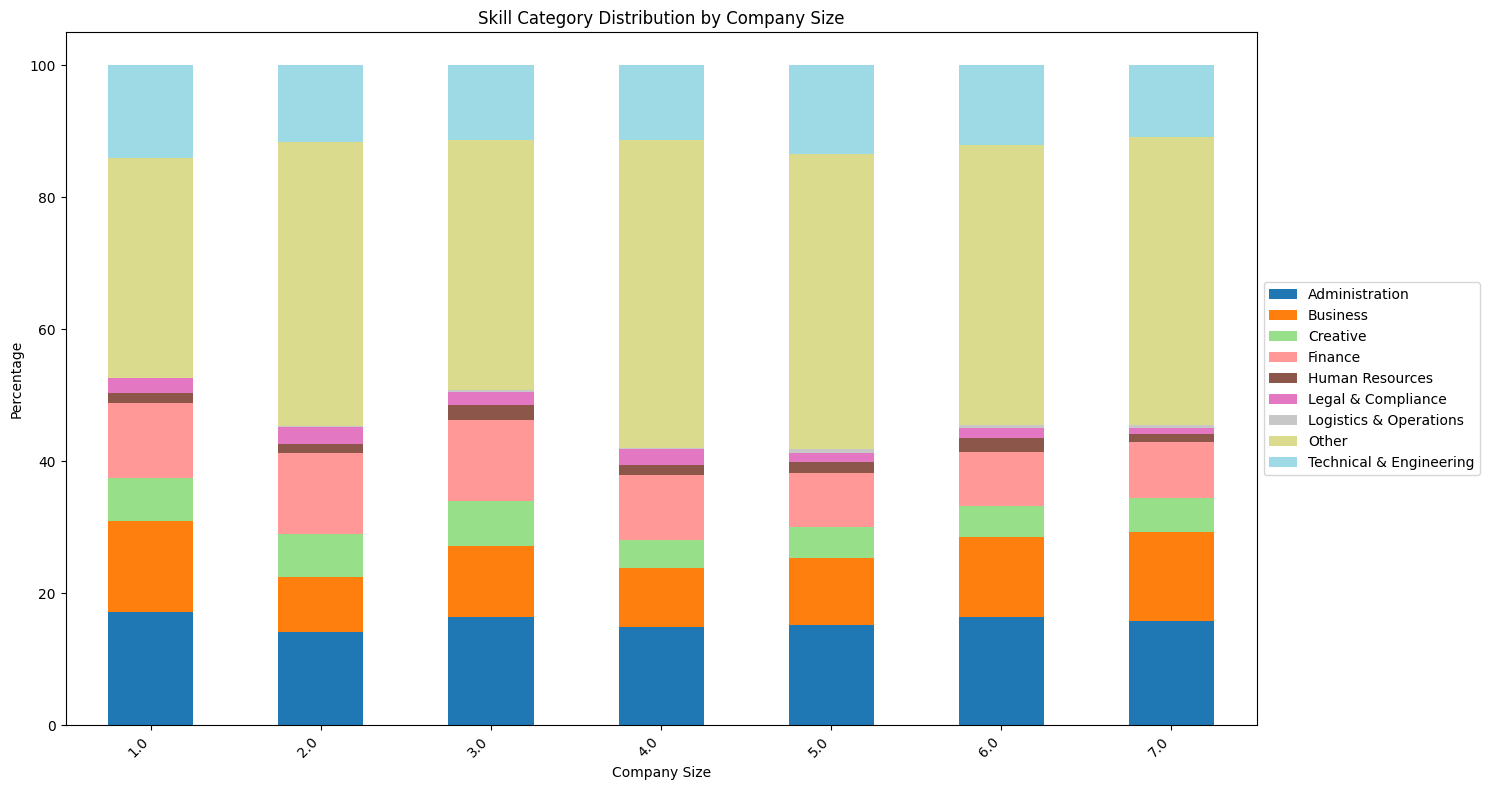

In [ ]:
# Draw stacked barplot
plt.figure(figsize=(20, 8))
company_size_skill.plot(kind='bar', x='company_size',stacked=True, colormap="tab20", figsize=(15, 8))
plt.title('Skill Category Distribution by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Skill Category')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

We can see that the distribution of skill categories is similar across different company sizes. 

## Multivariate Analysis

In [ ]:
# We want to perform analysis of industry, skill category and salary level, and visualize by cross-tabulation
industry_skill_salary = pd.crosstab(
    index=[df_labeled['industry_name'], df_labeled['skill_category']], 
    columns=df_labeled['salary_level'], 
    margins=True,
    margins_name='Total'
)
industry_skill_salary.reset_index(inplace=True)
industry_skill_salary

salary_level,industry_name,skill_category,High Salary,Low Salary,Medium Salary,Total
0,Accessible Architecture and Design,Administration,0,0,2,2
1,Accessible Architecture and Design,Creative,0,0,2,2
2,Accessible Architecture and Design,Technical & Engineering,0,0,2,2
3,Accommodation and Food Services,Business,0,0,26,26
4,Accommodation and Food Services,Technical & Engineering,0,0,13,13
...,...,...,...,...,...,...
1991,Writing and Editing,Administration,0,6,0,6
1992,Writing and Editing,Creative,14,9,3,26
1993,Writing and Editing,Other,7,10,44,61
1994,Writing and Editing,Technical & Engineering,0,1,7,8


In [ ]:
# Sort by high salary level
industry_skill_salary.sort_values('High Salary', ascending=False, inplace=False).head(5)

salary_level,industry_name,skill_category,High Salary,Low Salary,Medium Salary,Total
1995,Total,,74789,79003,154062,307854
779,Hospitals and Health Care,Other,4067,3822,7751,15640
821,IT Services and IT Consulting,Other,2171,2209,4796,9176
1715,Staffing and Recruiting,Other,2011,2250,3739,8000
588,Financial Services,Other,1618,1018,2973,5609


For all job postings across every industry that offered a high salary, the skill_category is listed as "other", which means the job may requires a variety of skills and maybe not suitable for a new graduate job seeker.

In [ ]:
# Eliminate skill_category list as 'Other'
industry_skill_salary[industry_skill_salary['skill_category'] != 'Other'].sort_values('High Salary', ascending=False)[1:6]

salary_level,industry_name,skill_category,High Salary,Low Salary,Medium Salary,Total
822,IT Services and IT Consulting,Technical & Engineering,929,487,1472,2888
8,Accounting,Finance,871,923,1884,3678
1515,Retail,Business,825,1483,2597,4905
589,Financial Services,Technical & Engineering,803,270,951,2024
585,Financial Services,Finance,775,1078,1968,3821


Here we can see Technical & Engineering, Finance, and Business are most highly paid skills.

## Synthesis

From our analysis, we were able to get some insight into our original research questions:
- What are the most common skills listed in job postings across various industries?

- How do job requirements vary across different industries?

- How could job hunters with different background find suitable jobs?
  
In our descriptive analysis part, 


## Reflection